<a href="https://colab.research.google.com/github/MinHyeok-lee1/AICamera/blob/master/MK_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [259]:
# 1. 필요한 라이브러리 다운로드
# Ignore the warnings
# 버전이 바뀌었을때 발생할 수 있는 오류들을 경고해주는 메시지
import warnings
#warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

from datetime import datetime
from pylab import rcParams
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier

# Model selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

In [261]:
# 2. 데이터 다운로드
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'

location = '/content/drive/MyDrive/Colab Notebooks/real_data.csv'
df = pd.read_csv(location, skiprows=1)



# 3. 데이터 전처리 함수
### Functinalize
### Feature engineering of default
df = df.query('거래처계층그룹명 != "합계"')

df[(df.수량).astype(int) < 0]

df.rename(columns = {'일자' : 'date'}, inplace = True)

df['date'] =  pd.to_datetime(df['date'])
df = df.set_index('date')

In [262]:
df.loc[df['품목코드'] == 'MK208', '품목코드'] = '208'
df.loc[df['품목코드'] == 'MK604', '품목코드'] = '604'
df.loc[df['품목코드'] == 'MKP000', '품목코드'] = '0'
df.loc[df['품목코드'] == 'MKP0013', '품목코드'] = '13'
df.loc[df['품목코드'] == 'MKP0014', '품목코드'] = '14'
df.loc[df['품목코드'] == 'MKP002', '품목코드'] = '2'
df.loc[df['품목코드'] == 'OASIS_MK1', '품목코드'] = '1'

df.loc[df['거래처코드'] == '401-01-89850', '거래처코드'] = '4010189850'

# df.loc[df['수량'] == '-1', '수량'] = -1
# df.loc[df['수량'] == '-2', '수량'] = -2
# df.loc[df['수량'] == '-3', '수량'] = -3
# df.loc[df['수량'] == '-4', '수량'] = -4
# df.loc[df['수량'] == '-5', '수량'] = -5
# df.loc[df['수량'] == '-10', '수량'] = -10
# df.loc[df['수량'] == '-40', '수량'] = -40


In [263]:
df.rename(columns = {'수량' : 'counts'}, inplace = True)
df.rename(columns = {'거래처코드' : 'store'}, inplace = True)
df.rename(columns = {'품목코드' : 'item'}, inplace = True)

In [265]:
# store / item 별로 월별 판매를 합산
df['counts']=df['counts'].astype(int)
df = df.groupby(['store', 'item'])['counts'].resample('M').sum()
df = df.reset_index()
df = df.set_index('date')

df['month'] = df.index.month
df['year'] = df.index.year
df['dayofweek'] = df.index.dayofweek
df['day'] = df.index.day

# 학습과 테스트 데이터 분리
df_train = df[df.index.year < 2021]
df_test = df[df.index.year >= 2021]

# split = "2020-09-01"
# df_train = df[:split]
# df_test = df[split:]


# dtype의 변경 
lbl = preprocessing.LabelEncoder()
df_train['store'] = lbl.fit_transform(df_train['store'].astype(float))
df_train['item'] = lbl.fit_transform(df_train['item'].astype(float))
# df_train['수량'] = lbl.fit_transform(df_train['수량'].astype(float))

df_test['store'] = lbl.fit_transform(df_test['store'].astype(float))
df_test['item'] = lbl.fit_transform(df_test['item'].astype(float))
# df_test['수량'] = lbl.fit_transform(df_test['수량'].astype(float))

# df_train['거래처코드'] = pd.to_numeric(df_train_x['거래처코드'])
# df_train['품목코드'] = pd.to_numeric(df_train_x['품목코드'])

df_train_y = df_train.loc[:,'counts']
df_train_x = df_train.drop('counts', axis=1)
df_test_y = df_test.loc[:,'counts']
df_test_x = df_test.drop('counts', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
df_test_orig = df_test.loc[:, ['store', 'item', 'counts']]
# df_test_orig = df_test.loc[:, ['판매처명', '품명 및 규격', '수량']]

df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1870 entries, 2021-01-31 to 2021-05-31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   store      1870 non-null   int64
 1   item       1870 non-null   int64
 2   counts     1870 non-null   int64
 3   month      1870 non-null   int64
 4   year       1870 non-null   int64
 5   dayofweek  1870 non-null   int64
 6   day        1870 non-null   int64
dtypes: int64(7)
memory usage: 116.9 KB


In [266]:
# dtype의 변경 
# df_train.loc[df_train['수량'] == '10-10', '수량'] = '0'
# df_train.loc[df_train['수량'] == '145-55', '수량'] = '90'
# df_train.loc[df_train['수량'] == '-5-310', '수량'] = '-315'
# df_train.loc[df_train['수량'] == '-2-2', '수량'] = '-4'
# df_train.loc[df_train['수량'] == '1-14-4', '수량'] = '-17'
# df_train.loc[df_train['수량'] == '3-333', '수량'] = '-330'

# df_test.loc[df_test['수량'] == '3-333', '수량'] = '-330'


lbl = preprocessing.LabelEncoder()
# df_train['수량'] = lbl.fit_transform(df_train['수량'].astype(float))
# df_test['수량'] = lbl.fit_transform(df_test['수량'].astype(float))

# df_train['거래처코드'] = pd.to_numeric(df_train_x['거래처코드'])
# df_train['품목코드'] = pd.to_numeric(df_train_x['품목코드'])

df_test_y

date
2021-01-31     2
2021-01-31     0
2021-02-28     0
2021-03-31    10
2021-04-30     0
              ..
2021-01-31     0
2021-02-28    10
2021-03-31    10
2021-04-30    10
2021-05-31    30
Name: counts, Length: 1870, dtype: int64

In [267]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=50,verbose=False)

preds = XG_model_month.predict(df_train_x)
rmse = np.sqrt(mean_squared_error(df_train_y, preds))
print("RMSE: %f" % (rmse))

[10:04:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 5.760172


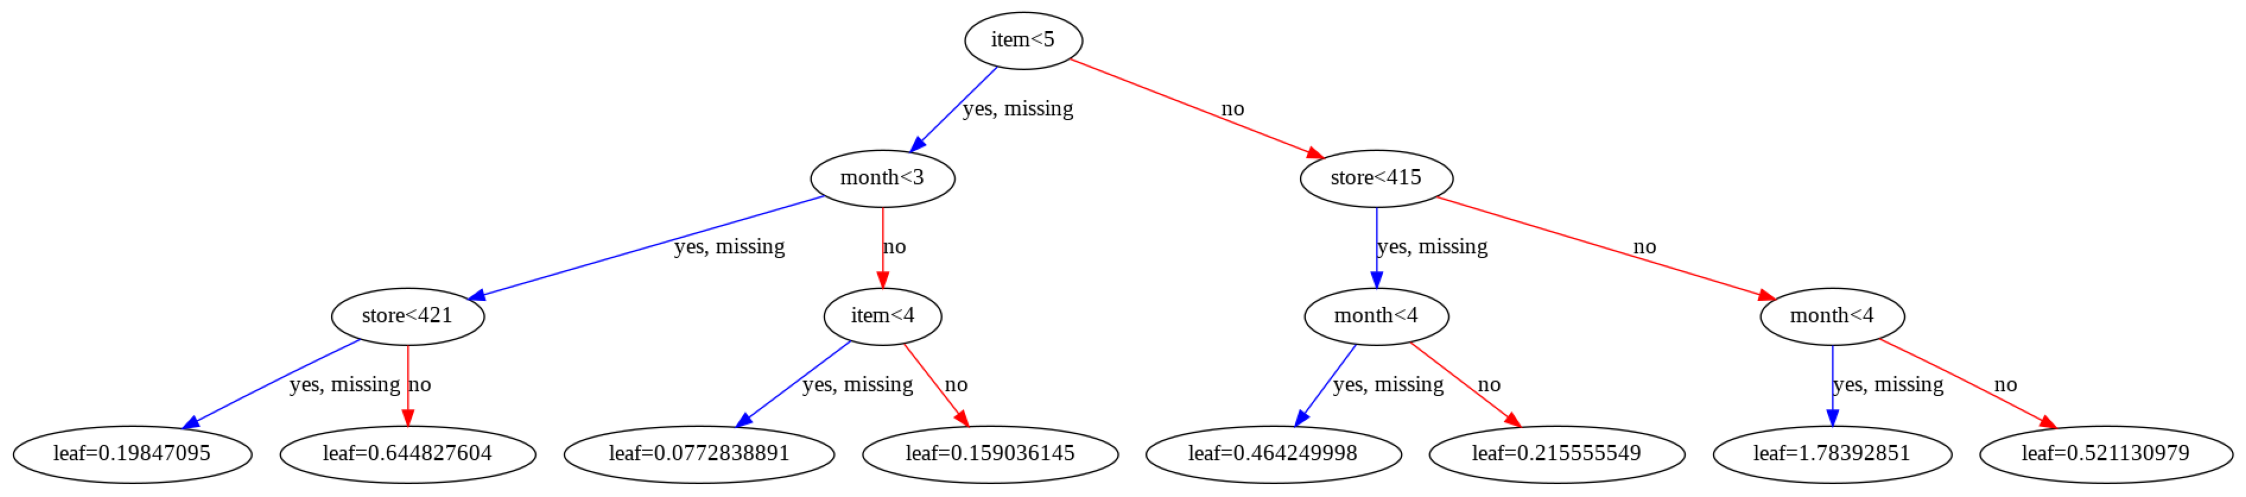

In [268]:
# 트리형태로 시각화
xgb.plot_tree(XG_model_month, num_trees=0)

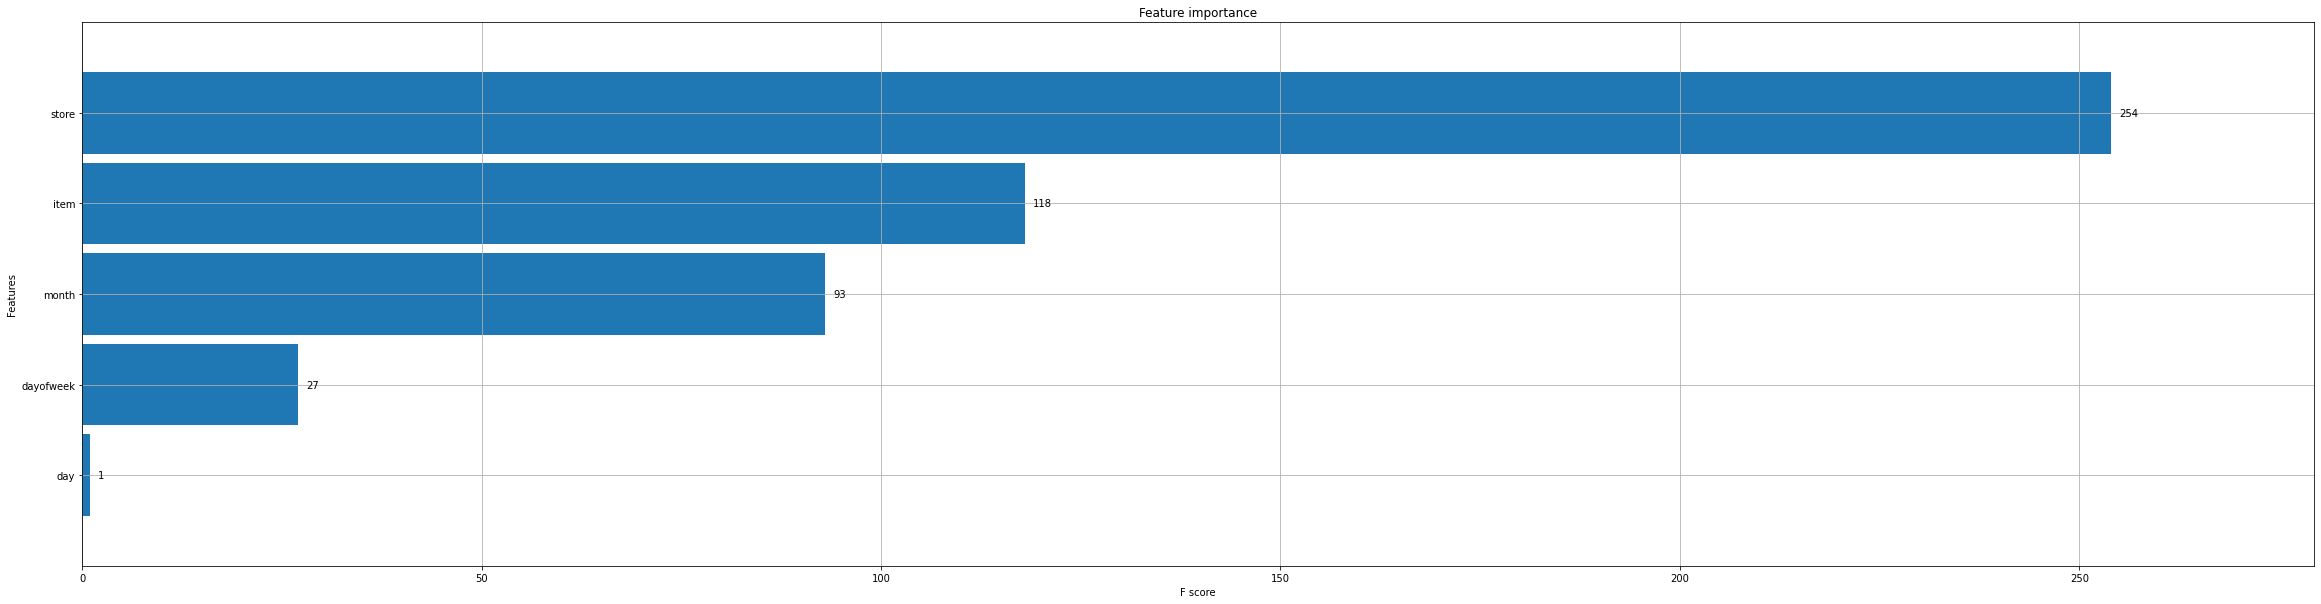

In [269]:
# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

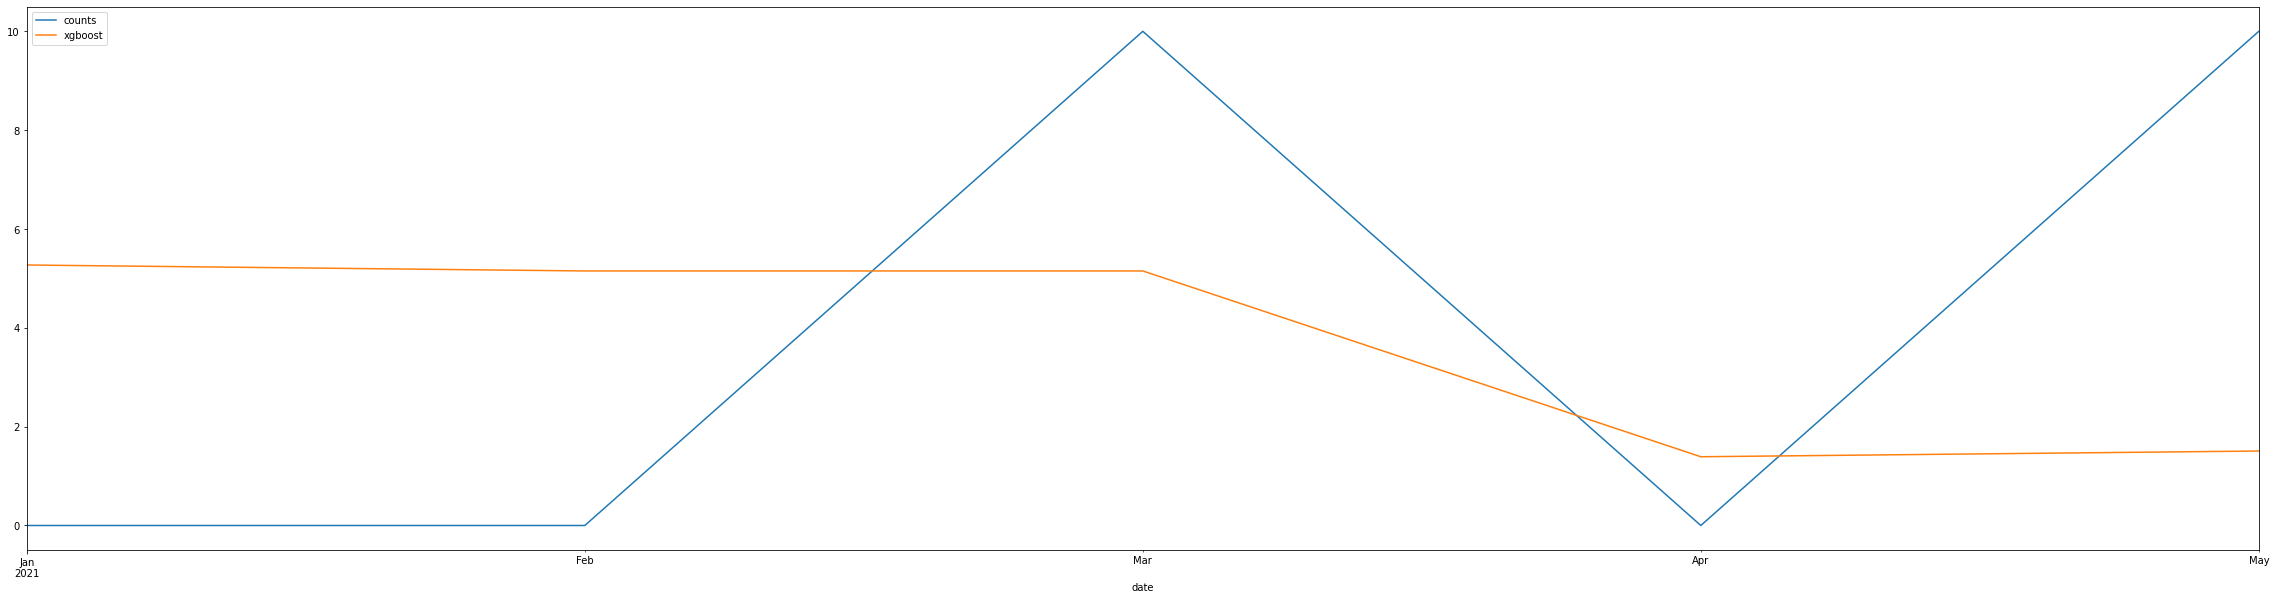

In [270]:
# 테스트 데이터 중 특정 store/item 데이터를 추출
# df0 = df_test_x[(df_test_x.store==1) & (df_test_x.item==700)]
df1 = df_test_x[(df_test_x.store==0) & (df_test_x.item==9)]

xgboost = XG_model_month.predict(df1)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
# result=pd.concat([df_test_orig[(df_test_orig.store==1)&(df_test_orig.item==700)].reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
result=pd.concat([df_test_orig[(df_test_orig.store==0)&(df_test_orig.item==9)].reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)

result = result.set_index('date')
result = result.loc[:, ['counts', 'xgboost']]
result.plot()